In [0]:
import pandas as pd
import numpy as np
import requests, json

api_key = '70D413B2-0123-3524-9634-F730BE441009' 

#years used in study
years = map(str,range(1981,2018))

#states used in study
states = ['IL','IN','IA','KS','KY','MI','MO','NE','OH','SD','WI']

payload = {'key':api_key,
          'source_desc':'SURVEY', 
           'sector_desc':'CROPS',
           'group_desc':'FIELD CROPS',
           'commodity_desc':'CORN', 
           'util_practice_desc':'ALL UTILIZATION PRACTICES', 
           'statisticcat_desc':'PROGRESS',
           'domain_desc':'TOTAL', 
           'state_alpha':states,
           'year':years,
           'format':'JSON'}

#disable copy of slice warning
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
#df will contain Dented, Dough, Emerged, Mature, Planted, Silking
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
df = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#Still need harvested phase so change payload to grain which will allow us to access it
payload['util_practice_desc'] = 'GRAIN'
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
dfG = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#concatenate the two dataframes together because dfG contains that percent harvested while df contains all other phases
#save the raw data incase the gov't shuts down...
df = pd.concat([df,dfG])
df.to_excel('progress_data_raw.xlsx')
df.to_csv('progress_data_raw.csv')

NameError: ignored

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

In [0]:
#Select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

In [0]:
#This is what unedited df looks like. Dates and values only once per week. Want to change this so have a value every day of the week.
dfp.head(10)

,week_ending,Value
11182,2018-04-01,0
11183,2018-04-08,0
11184,2018-04-15,0
11185,2018-04-22,4
11186,2018-04-29,32
11187,2018-05-06,74
11188,2018-05-13,90
11189,2018-05-20,96
11190,2018-05-27,100
11191,2018-06-03,100


In [0]:
#sanity check to see if picked out state and phase correctly. should return only one value.
dfp[dfp.week_ending == '2017-04-09']

,week_ending,Value
11193,2017-04-09,1


In [0]:
#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)
dfp.head(10)

,Value
week_ending,
2018-04-01,0
2018-04-08,0
2018-04-15,0
2018-04-22,4
2018-04-29,32
2018-05-06,74
2018-05-13,90
2018-05-20,96
2018-05-27,100


In [0]:
#need to extend date range so it runs from 01-01-1981 to 12-31-2017 and has daily points not weekly.

ix = pd.date_range(start= '01-01-1981', end = '12-31-2017', freq = 'D')
dfp = dfp.reindex(ix)

dfp.head()

,Value
1981-01-01,NaN
1981-01-02,NaN
1981-01-03,NaN
1981-01-04,NaN
1981-01-05,NaN


In [0]:
#locate a specific year
#assume 0% progress at start of each year for each phase and 100% progress at end of each year for each phase
df_2017 = dfp.loc['2017']
df_2017.iloc[0,0] = 0
df_2017.iloc[-1] = 100
df_2017.head()

,Value
2017-01-01,0.0
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [0]:
#will not work because I have NaN values 
#df_2017.plot()

In [0]:
df_2017.loc['2017-04-09':'2017-04-16']

,Value
2017-04-09,1.0
2017-04-10,NaN
2017-04-11,NaN
2017-04-12,NaN
2017-04-13,NaN
2017-04-14,NaN
2017-04-15,NaN
2017-04-16,6.0


In [0]:
#resample to ensure  we now have daily data ('D'). should see a lot of NaN because still need to interpolate Value column
resampled_dfp = df_2017.resample('D')
resampled_dfp.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called head(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


,Value
2017-01-01,0.0
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-07,NaN
2017-01-08,NaN
2017-01-09,NaN
2017-01-10,NaN


In [0]:
#use linear interpolation to get daily Values
interpolated = resampled_dfp.interpolate(method = 'linear')
print(interpolated.head(20))

               Value
2017-01-01  0.000000
2017-01-02  0.010204
2017-01-03  0.020408
2017-01-04  0.030612
2017-01-05  0.040816
2017-01-06  0.051020
2017-01-07  0.061224
2017-01-08  0.071429
2017-01-09  0.081633
2017-01-10  0.091837
2017-01-11  0.102041
2017-01-12  0.112245
2017-01-13  0.122449
2017-01-14  0.132653
2017-01-15  0.142857
2017-01-16  0.153061
2017-01-17  0.163265
2017-01-18  0.173469
2017-01-19  0.183673
2017-01-20  0.193878


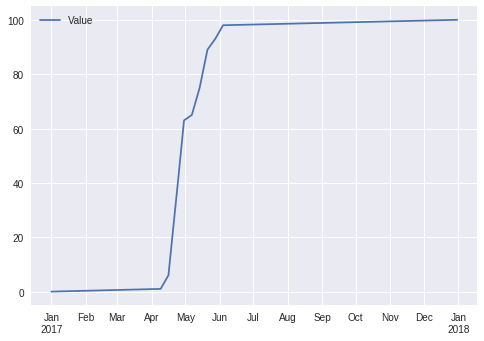

In [0]:
#visualize 2017 percent planted data
interpolated.plot()

In [0]:
#Now we need to figure out how to do this for EVERY YEAR in a specific phase in Illinois

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

#select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)

#need to extend date range so it runs from 01-01-1981 to 12-31-2017 and has daily points not weekly.
ix = pd.date_range(start= '01-01-1981', end = '12-31-2017', freq = 'D')
dfp = dfp.reindex(ix)

#find all the unique years
yrs = list(dfp.index.year.unique())

df_all = pd.DataFrame()
for y in yrs:
  df_year = dfp.loc[str(y)]
  df_year.iloc[0,0] = 0
  df_year.iloc[-1] = 100
  
  resampled_dfp = df_year.resample('D')
  interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
  df_all = pd.concat([df_all, interpolated_dfp], axis = 0)

In [0]:
#Now we need to figure out how to do this for every year in EVERY PHASE in Illinois

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#list all the phases
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE'] #removed PCT HARVESTED b/c duplicate dates

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  yrs = list(dfp.index.year.unique())
  
  df_specific_phase_all_years = pd.DataFrame() #prime the empty dataframe to collect specific phase data for every year
  
  for y in yrs:
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
  
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  print(p)
  
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

#there will be a lot of NaN values b/c while the crop is in one phase it cannot be in the other. rows should usually only have one value.
df_all_phases_all_years.fillna(0, inplace = True)

#df_all_phases_all_years.to_csv('illinois_development_data.csv', header = True, index = True)

PCT PLANTED
PCT SILKING
PCT DOUGH
PCT DENTED
PCT MATURE


In [0]:
df_all_phases_all_years.loc['1980-01-01':'1981-12-31']

,PCT PLANTED,PCT SILKING,PCT DOUGH,PCT DENTED,PCT MATURE
week_ending,,,,,
1980-04-27,0.000000,0.0,0.0,0.000000,0.000000
1980-04-28,6.571429,0.0,0.0,0.000000,0.000000
1980-04-29,13.142857,0.0,0.0,0.000000,0.000000
1980-04-30,19.714286,0.0,0.0,0.000000,0.000000
1980-05-01,26.285714,0.0,0.0,0.000000,0.000000
1980-05-02,32.857143,0.0,0.0,0.000000,0.000000
1980-05-03,39.428571,0.0,0.0,0.000000,0.000000
1980-05-04,46.000000,0.0,0.0,0.000000,0.000000
1980-05-05,51.714286,0.0,0.0,0.000000,0.000000


In [0]:
#TEST CELL

#use the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#list all the phases
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE'] #removed PCT HARVESTED b/c duplicate dates

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  yrs = list(dfp.index.year.unique())
  
  df_specific_phase_all_years = pd.DataFrame() #prime the empty dataframe to collect specific phase data for every year
  
  for y in yrs:
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
    
    #need to extend date range so it runs from 01-01-1981 to 12-31-2017 and has daily points not weekly.
    #ix = pd.date_range(start= '01-01-'+str(y), end = '12-31-'+str(y), freq = 'D')
    #dfp = dfp.reindex(ix)
  
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  print(p)
  
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

#there will be a lot of NaN values b/c while the crop is in one phase it cannot be in the other. rows should usually only have one value.
df_all_phases_all_years.fillna(0, inplace = True)

#df_all_phases_all_years.to_csv('illinois_development_data.csv', header = True, index = True)


In [0]:
dfp

In [0]:
#should see a lot of zeros (used to be NaN) b/c not all phases have data for the same dates
df_all_phases_all_years.head()

,week_ending,Value
7854,2018-08-19,1
7855,2018-08-26,11
7856,2018-09-02,36
7857,2018-09-09,56
7858,2018-09-16,75


In [0]:
df_all_phases_all_years.loc['2018-05-30':'2018-08-29']

,PCT PLANTED,PCT SILKING,PCT DOUGH,PCT DENTED,PCT MATURE
week_ending,,,,,
2018-05-30,100.0,0.000000,0.000000,0.000000,0.000000
2018-05-31,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-01,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-02,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-03,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-04,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-05,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-06,100.0,0.000000,0.000000,0.000000,0.000000
2018-06-07,100.0,0.000000,0.000000,0.000000,0.000000


In [0]:
df_all_phases_all_years['PCT SILKING'].max()

100.0

In [0]:
#should see a lot of zeros (used to be NaN) for left side columns
df_all_phases_all_years.tail()

,PCT PLANTED,PCT SILKING,PCT DOUGH,PCT DENTED,PCT MATURE
week_ending,,,,,
2018-10-10,0.0,0.0,0.0,0.0,100.0
2018-10-11,0.0,0.0,0.0,0.0,100.0
2018-10-12,0.0,0.0,0.0,0.0,100.0
2018-10-13,0.0,0.0,0.0,0.0,100.0
2018-10-14,0.0,0.0,0.0,0.0,100.0


In [0]:
#figure out how to convert cdf to pdf
import matplotlib.pyplot as plt
import copy
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)

In [0]:
#work with subset of data
#NEED TO FIX INTERPOLATED DATA NEED TO ADD EXTRA DATES BECASUE DATA DOES NOT START AT JAN 1 AND END AT DEC 31

In [0]:
#plot what the development data currently looks like 
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

for i in df.columns:
  dfp = copy.deepcopy(df[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [0]:
#testing out gradient to take derivative of series
import numpy as np
test = {'counter':[1,2,3,4,5,6,7,8,9,10,11], 'cats':[0,2,4,6,8,10,12,14,16,18,20]}
test = pd.DataFrame.from_dict(test)
test.set_index('counter', inplace = True)

y = test.cats.values
j = np.gradient(y)

test['gradient'] = j

x =test.index
y1 = test.cats.values
y2 = test.gradient.values

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()


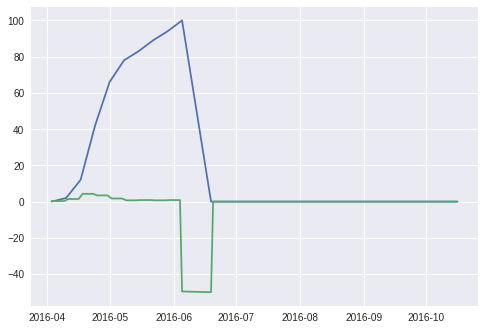

In [104]:
#This looks pretty bad...
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

dfp = copy.deepcopy(df[['PCT PLANTED']])

#np.gradient(dfp.values)

dfp['gradient'] = np.gradient(dfp['PCT PLANTED'].values)

x = dfp.index
y1 = dfp['PCT PLANTED']
y2 = dfp['gradient']

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()


In [10]:
dfp.columns

AttributeError: ignored